# Import the libraries

To perform the classical machine-learning steps we use the tensorflow software package.

Quantum circuits can be added as a layer to a tensorflow model by using the tensorflow-quantum software package.


In [1]:
import tensorflow as tf

In [2]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

import tensorflow as tf

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras import initializers

import random
import pickle
import pandas as pd
import cv2

# visualization tools
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit






### Set the hyper-parameters

For this example, we choose whether to use the unary amplitude encoding or the product state encoding, the PCA vs autoencoder compression and the number of qubits


In [3]:
unary_enc = False;
PCA_enc=True;
Nq=4;


In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# Rescale the images from [0,255] to the [0.0,1.0] range.
X_train, X_test = X_train[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(X_train))
print("Number of original test examples:", len(X_test))

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

X_train, y_train = filter_36(X_train, y_train)
X_test, y_test = filter_36(X_test, y_test)

print("Number of filtered training examples:", len(X_train))
print("Number of filtered test examples:", len(X_test))

Number of original training examples: 60000
Number of original test examples: 10000
Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [5]:
X_train.shape

(12049, 28, 28, 1)

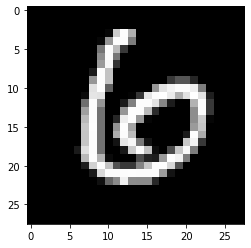

In [6]:
plt.imshow(X_test[0],cmap='gray')

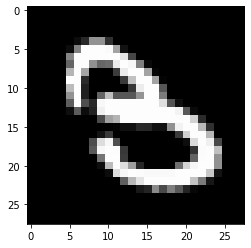

In [7]:
plt.imshow(X_test[1],cmap='gray')

<br> <br> <br> 
## Compress the Data Using the PCA compression scheme.  Load the compressed data into a quantum circuit

In [8]:
print("Number of filtered training examples:", len(X_train))
print("Number of filtered test examples:", len(X_test))


#Apply Principle Component Analysis
def truncate_x(x_train, x_test, n_components=16):

  #Perform PCA on image dataset keeping the top `n_components` components
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])

DATASET_DIM = Nq
X_train_pc, X_test_pc = truncate_x(X_train, X_test, n_components=DATASET_DIM)

X_train_pc = np.array(X_train_pc)-0.0*np.min(X_train_pc)
X_test_pc = np.array(X_test_pc)-0.0*np.min(X_train_pc)
print(f'New datapoint dimension:', len(X_train_pc[0]))




Number of filtered training examples: 12049
Number of filtered test examples: 1968


2022-08-17 08:27:48.820303: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


New datapoint dimension: 4


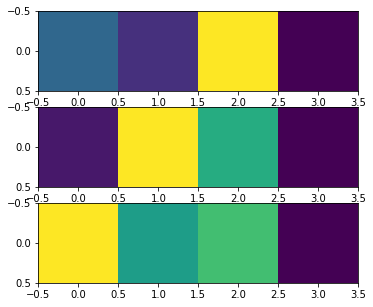

In [9]:
plt.subplots(figsize=(20,5))
ax = plt.subplot(3, 1,  1)
plt.imshow((X_train_pc[int(0)].reshape(1,Nq)), cmap='viridis')
ax = plt.subplot(3, 1,  2)
plt.imshow((X_train_pc[int(100)].reshape(1,Nq)), cmap='viridis')
ax = plt.subplot(3, 1,  3)
plt.imshow((X_train_pc[int(2000)].reshape(1,Nq)), cmap='viridis')

<br> <br> 
## Convert the Dimensionally Reduced Data to "Quantum Data"

In [10]:
def convert_to_product_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)/np.max(np.abs(image))
    qubits = cirq.LineQubit.range(Nq)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
            circuit.append(cirq.ry(value*np.pi/2.0).on(qubits[i]))
    return circuit




def RBS(circuit, qubits, i, j, theta):
    circuit.append(cirq.H(qubits[j]))
    circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.CZ(qubits[j],qubits[i]))
    circuit.append(cirq.ry(theta/2.0).on(qubits[i]))
    circuit.append(cirq.ry(-theta/2.0).on(qubits[j]))
    circuit.append(cirq.CZ(qubits[j],qubits[i]))
    circuit.append(cirq.H(qubits[j]))
    circuit.append(cirq.H(qubits[i]))


def convert_to_unary_amp_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(Nq, 1)
    circuit = cirq.Circuit()

    d=len(values)
    d2=int(len(values)/2)
    r=[0]*(d-1)
    angle=[0]*d


    for j in range(1,d2+1):
        r[d2+j-2] = (values[2*j-1]**2.0 + values[2*j-1-1]**2.0)**0.5+1e-10;

    for j in range(d2-1,0,-1):
        r[j-1] = (r[2*j]**2.0 + r[2*j-1]**2.0)**0.5 + 1e-10

    for j in range(1,d2+1):
        if(values[2*j-1]>0):
            angle[d2+j-2] = np.arccos(values[2*j-2]/r[d2+j-2]);
        else:
            angle[d2+j-2] = 2*np.pi - np.arccos(values[2*j-2]/r[d2+j-2]);

    for j in range(1,d2):
        angle[j-1] = np.arccos(r[2*j-1]/r[j-1]);

    circuit.append(cirq.X(qubits[0]))



    for j in range(int(np.log2(d))):
        for k in range(2**j):
            s1 = d/(2**j)*k
            s2 = d/(2**(j+1))
            #iRBS(circuit, int(s1), int(s1+s2), angle[2**(j)+k-1])
            RBS(circuit, qubits, int(s1), int(s1+s2), angle[2**(j)+k-1]*2.0)
            #circuit.append(cirq.ops.PhasedFSimGate(angle[2**j +k-1],chi=np.pi/2.0).on(qubits[int(s1)],qubits[int(s1+s2)]))


    return circuit



### Visualize the Loading Circuits

In [11]:
convert_to_unary_amp_circuit(X_train_pc[0])

(0, 0): ───X───H───@───Ry(0.25π)────@───H───H───@───Ry(1.3π)─────@───H───
                   │                │           │                │
(1, 0): ───H───────┼────────────────┼───────────@───Ry(-1.3π)────@───H───
                   │                │
(2, 0): ───H───────@───Ry(-0.25π)───@───H───H───@───Ry(1.57π)────@───H───
                                                │                │
(3, 0): ───H────────────────────────────────────@───Ry(-1.57π)───@───H───

### Output the Wavefunction corresponding to the loaded data
Note that the wave-function on N qubits is a 2^N vector.  With the amplitude encoding, only N of the entries are nonzero.

In general, the advantage from Quantum ML comes from the ability to manipulate vectors in an exponentially large vector space.

In [12]:
cirq_simulator = cirq.Simulator()
final_state_vector = cirq_simulator.simulate(convert_to_unary_amp_circuit(X_train_pc[0])).final_state_vector
np.set_printoptions(precision=4,suppress=True)
print("4D Image Data: \t \t", X_train_pc[0]/np.linalg.norm(X_train_pc[0]),'\n')
print("2^4-D wavefunction:" ,'\n', final_state_vector)

4D Image Data: 	 	 [-0.4109 -0.5746  0.1515 -0.6914] 

2^4-D wavefunction: 
 [ 0.    +0.j -0.6914+0.j  0.1515+0.j -0.    +0.j -0.5746+0.j -0.    +0.j
  0.    +0.j -0.    +0.j -0.4109+0.j -0.    +0.j  0.    +0.j  0.    +0.j
  0.    +0.j -0.    +0.j -0.    +0.j -0.    +0.j]


#### Look at the circuit and the output wavefunction for the product state encoding

In [13]:
convert_to_product_circuit(X_train_pc[0])

0: ───Ry(-0.297π)───

1: ───Ry(-0.416π)───

2: ───Ry(0.11π)─────

3: ───Ry(-0.5π)─────

In [14]:
final_state_vector = cirq_simulator.simulate(convert_to_product_circuit(X_train_pc[0])).final_state_vector
print("2^4-D wavefunction:" ,'\n', final_state_vector)

2^4-D wavefunction: 
 [ 0.4942+0.j -0.4942+0.j  0.0859+0.j -0.0859+0.j -0.3779+0.j  0.3779-0.j
 -0.0657+0.j  0.0657-0.j -0.249 +0.j  0.249 -0.j -0.0433+0.j  0.0433-0.j
  0.1904+0.j -0.1904+0.j  0.0331+0.j -0.0331+0.j]


# Create the Quantum CNN Circuit

To accomplish this, first we define the basic one and two-qubit unitary gates 

In [15]:
#Create training circuit

def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2]
        )


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += [cirq.Z(bits[1])**symbols[12]]
    circuit += [cirq.CNOT(bits[0],bits[1])]
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.CNOT(bits[0],bits[1])]
    circuit += [cirq.X(bits[0])**symbols[13]]
    circuit += [cirq.Z(bits[1])**symbols[14]]
    circuit += [cirq.CNOT(bits[0],bits[1])]
    circuit += one_qubit_unitary(bits[0], symbols[6:9])
    circuit += one_qubit_unitary(bits[1], symbols[9:12])
    
    return circuit



In [16]:
state_bits = cirq.LineQubit.range(1)
sym3 = sympy.symbols('a0:3')
one_qubit_unitary(state_bits[0],sym3)

0: ───X^a0───Y^a1───Z^a2───

In [17]:
state_bits = cirq.LineQubit.range(2)
sym3 = sympy.symbols('a0:15')
two_qubit_unitary(state_bits,sym3)

0: ───────────@───X^a0───Y^a1───Z^a2────────────────────────@───X^a13───@───X^a6───Y^a7───Z^a8──────────────────────────
              │                                             │           │
1: ───Z^a12───X────────────────────────X^a3───Y^a4───Z^a5───X───Z^a14───X────────────────────────X^a9───Y^a10───Z^a11───

## Define Functions to Create the qCNN

Here we organize the one and two qubit unitary operators into the quantum CNN architecture. 

We define the number of layers we apply, the number of unitaries gates per layer, and the connectivity between the different unitary gates.

In [18]:
def quantum_conv_circuit(bits, symbols, last):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    if(last==False):
        for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
            circuit += two_qubit_unitary([first, second], symbols)
            
    return circuit



def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:60')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15],False)

    if(Nq==4):
        model_circuit += quantum_conv_circuit(qubits[::2], symbols[15:30],True)
    else:
        model_circuit += quantum_conv_circuit(qubits[::2], symbols[15:30],False)

    if(Nq>4):
        model_circuit += quantum_conv_circuit(qubits[::4], symbols[30:45],True)
    if(Nq>8):
        model_circuit += quantum_conv_circuit(qubits[::8], symbols[45:60],True)
    
    return model_circuit



## Define the qCNN circuit as a Tensorflow model

We pass the quntum circuit in to the PQC object, and initialize the rotation angles in our circuit.  

In [19]:
##We define the hinge-accuracy by converting category labels to +/- 1
##This allows us to simply use the <Z> expectation value as a classifier

state_bits = cirq.LineQubit.range(Nq)
readout_operators = [cirq.Z(state_bits[0])]

model_circuit = create_model_circuit(state_bits)


In [20]:
from cirq.contrib.svg import SVGCircuit


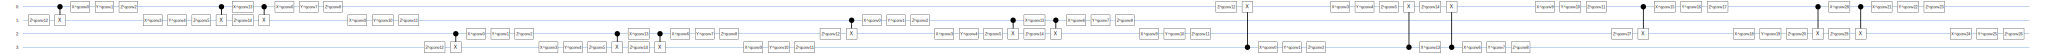

In [21]:
SVGCircuit(model_circuit)

In [22]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

# SPSA with Manual Job Submission



In [23]:
np_tot = 30;
symbols = sympy.symbols('qconv0:30')
sym_dict = {};
for i in range(len(symbols)):
    sym_dict[symbols[i]] = 0.0;

In [24]:
simulator = cirq.Simulator()
mse = tf.keras.losses.MeanSquaredError();

In [27]:
import time 

##The spsa hyperparameters
a=0.05; b=0.05; s=.602; t=.101 ; 
gamma=0.0; max_it=200;
num_shots = 1000;
qpu = False;



num_its=100;  #The number of iterations
NUM_EXAMPLES=5;

kstart=0;
freq = 5;
hinge=True

if(kstart==0):
    loss_value_k = []
    acc_value_k = [];
    param_values_k = [];
    acc_value_0 = []
    loss_value_0=[];
    loss_value = [];
    acc_value = [];
    loss_value1 = [];
    acc_value1 = [];



start = time.time()

for x in range(1):

    print(x);
    l_avg_old = 0
    a_avg_old = 0;

    if(kstart==0):
        initial_point = (0.0*np.random.rand(np_tot,1)*2.0*np.pi).astype('f')
        param_values_k.append(initial_point)

    else:
        initial_point = param_values_k[kstart];
        
    v_old = np.random.rand(np_tot,1)*0.0;    
    
    l_avg = 0;
    a_avg = 0;
    t_avg=0;
    
    
    for k in range(kstart,num_its):
    
        t0 = time.time()
        
        #Adjust the number of samples per iteration to increase at higher iterations
        if(k<=20):
            NUM_EXAMPLES=20;
        if(k>20 and k<70):
            NUM_EXAMPLES=50;
        elif(k>70 and k<100):
            NUM_EXAMPLES=200;
        elif(k>100):
            NUM_EXAMPLES=200;  
            
            
            

        #Get a new mini-batch of images to evaluate the function on
        indices = tf.range(start=0, limit=tf.shape(X_train_pc)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        shuffled_y = tf.gather(y_train_hinge, shuffled_indices)
    
      

        #the SPSA loop
        lr_k =  a/(k+1.0+max_it*.01)**s;
        perturb_k = b / (k+1.0)**t;
        delta_k = 2.0*(2.0*np.random.rand(np_tot,1)-1.0).astype('f')
       
    
        jobid_plus = [];
        jobid_minus = [];

        sym_dict_plus = {}
        sym_dict_minus = {}
        
        #Set the parameters for the two circuits
        for i in range(np_tot):
            sym_dict_plus[symbols[i]] = initial_point[i][0] + perturb_k*delta_k[i][0]
            sym_dict_minus[symbols[i]] = initial_point[i][0] - perturb_k*delta_k[i][0]


        output_plus = [];
        output_minus = [];


        l_plus = 0.0;
        l_minus=0.0;
        
        for i in range(NUM_EXAMPLES):
                               
            circ1 = cirq.Circuit()
            circ1 += convert_to_product_circuit(X_train_pc[shuffled_indices[i]])
            circ1 += model_circuit
            circ1 += cirq.measure(state_bits[0],key='x')
            
            circ_plus =cirq.resolve_parameters(circ1,sym_dict_plus)
            circ_minus =cirq.resolve_parameters(circ1,sym_dict_minus)
        
        
            results_plus = simulator.run(circ_plus, repetitions=num_shots)
            results_minus = simulator.run(circ_minus, repetitions=num_shots)
            
            out_plus =(1.0 - 2.0*results_plus.measurements['x']).sum()/num_shots
            out_minus = (1.0 - 2.0*results_minus.measurements['x']).sum()/num_shots

                    
            output_plus.append( out_plus )
            output_minus.append( out_minus )
                      
            l_plus += mse(output_plus[i:i+1],shuffled_y[i:i+1])
            l_minus += mse(output_minus[i:i+1],shuffled_y[i:i+1])               

                
                
        l_plus = l_plus/NUM_EXAMPLES
        l_minus = l_minus/NUM_EXAMPLES

        a_plus = hinge_accuracy(output_plus,shuffled_y[:NUM_EXAMPLES])
        a_minus = hinge_accuracy(output_minus,shuffled_y[:NUM_EXAMPLES])
    
        
        #Determine the new update parameters
        g_k = ( l_plus - l_minus ) / (2.0*perturb_k);
    
        v_new = gamma*v_old + lr_k*g_k*delta_k
        v_old = v_new;
    
        new_point = (initial_point - v_new.numpy() ).astype('f');
    
        initial_point = new_point;
        
        param_values_k.append(initial_point)

        l_avg += ((l_plus+l_minus)/2.0).numpy();
        a_avg += ((a_plus+a_minus)/2.0).numpy();

        t1 = time.time();
        t_avg += (t1-t0);
       


        print(k, l_plus.numpy(), l_minus.numpy(), a_plus.numpy(), a_minus.numpy())

        loss_value_0.append( ((l_plus+l_minus)/2.0).numpy() )
        acc_value_0.append( ((a_plus+a_minus)/2.0).numpy() )


        if(k%freq==0):   
            if(k==0):
                l_avg = round(l_avg,5)
                a_avg = round(a_avg,5)
            else:
                l_avg = round(l_avg/freq,5)
                a_avg = round(a_avg/freq,5)
            loss_value.append(l_avg)
            acc_value.append(a_avg)
            
            print("avg: ", k, l_avg, a_avg, '\t\t', round(lr_k,5), round(perturb_k,5), round(g_k.numpy(),5), t_avg)
            
            l_avg_old = l_avg;
            a_avg_old= a_avg;
            l_avg = 0;
            a_avg=0;
            t_avg = 0
            

    loss_value_k.append(loss_value)
    acc_value_k.append(acc_value)
    
end=time.time()


0
0 0.9729333896189928 0.9664125889539719 0.4 0.65
avg:  0 0.96967 0.525 		 0.02581 0.05 0.06521 0.7161362171173096
1 0.8430621966719627 0.8329565972089767 0.9 0.75
2 0.8850068010389804 0.8392789974808693 0.8 0.7
3 0.9764714010059834 0.9790936114732176 0.45 0.5
4 1.3100654065608979 0.9682528018951416 0.15 0.65
5 1.045502606034279 1.3057953983545303 0.65 0.1
avg:  5 0.99855 0.565 		 0.0143 0.04172 -3.11929 3.3162381649017334
6 1.0200505767017602 1.0304487943649292 0.65 0.6
7 1.2451228126883507 1.1058001875877381 0.5 0.45
8 1.079664196074009 1.0370877854526044 0.55 0.55
9 1.1207661837339402 0.9632020056247711 0.55 0.6
10 0.8642686024308205 1.0473449990153312 0.85 0.55
avg:  10 1.05138 0.585 		 0.01068 0.03925 -2.33245 3.3334479331970215
11 1.0132049962878227 0.8043889999389648 0.6 0.7
12 1.2515629924833775 0.8525213986635208 0.4 0.65
13 0.8626568019390106 1.0660137988626956 0.6 0.5
14 0.9017357990145684 0.7766259901225567 0.7 0.75
15 0.8369260028004646 0.9939242102205753 0.75 0.55
avg:  

## Visualize The Output

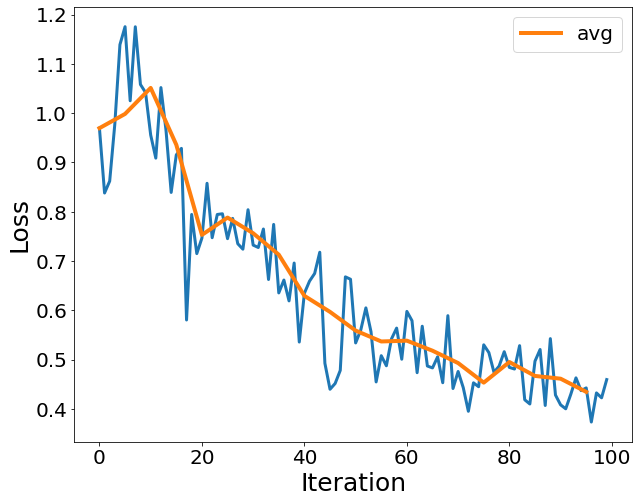

In [28]:
plt.figure(figsize=(10,8))
plt.plot(loss_value_0, linewidth=3)
plt.plot(range(0,100,5),loss_value, linewidth=4, label='avg')
plt.xlabel('Iteration',fontsize=25)
plt.ylabel('Loss',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

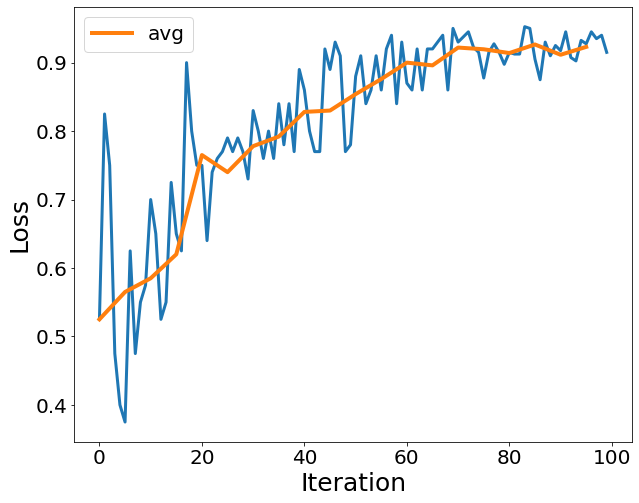

In [29]:
plt.figure(figsize=(10,8))
plt.plot(acc_value_0, linewidth=3)
plt.plot(range(0,100,5),acc_value, linewidth=4, label='avg')
plt.xlabel('Iteration',fontsize=25)
plt.ylabel('Loss',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

## Run the Validation Loop

In [32]:
import time 

##The spsa hyperparameters
a=0.05; b=0.05; s=.602; t=.101 ; 
gamma=0.0; max_it=200;
num_shots = 1000;
qpu = False;



num_its=100;  #The number of iterations
NUM_EXAMPLES=50;

kstart=0;
freq = 5;
hinge=True



start = time.time()

for x in range(1):

    print(x);
    l_avg_old = 0
    a_avg_old = 0;

  
    
    l_avg = 0;
    a_avg = 0;
    t_avg=0;
    
    val_acc = [];
    
    
    for k in range(kstart,num_its):
    
        initial_point = param_values_k[k]
    
        t0 = time.time()
                      

        #Get a new mini-batch of images to evaluate the function on
        indices = tf.range(start=0, limit=tf.shape(X_test_pc)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        shuffled_y = tf.gather(y_test_hinge, shuffled_indices)
    
      

        #the SPSA loop

        sym_dict = {}
        
        #Set the parameters for the two circuits
        for i in range(np_tot):
            sym_dict[symbols[i]] = initial_point[i][0] 


        output= [];


        l_0 = 0.0;
        a_0 =0.0;
        
        for i in range(NUM_EXAMPLES):
                               
            circ1 = cirq.Circuit()
            circ1 += convert_to_product_circuit(X_test_pc[shuffled_indices[i]])
            circ1 += model_circuit
            circ1 += cirq.measure(state_bits[0],key='x')
            
            
            circuit =cirq.resolve_parameters(circ1,sym_dict)
        
        
            results_plus = simulator.run(circuit, repetitions=num_shots)
            
            out_1 =(1.0 - 2.0*results_plus.measurements['x']).sum()/num_shots

                    
            output.append( out_1 )
                      
            l_0 += mse(output[i:i+1],shuffled_y[i:i+1])

                
                
        l_0 = l_0/NUM_EXAMPLES

        a_0 = hinge_accuracy(output[:NUM_EXAMPLES],shuffled_y[:NUM_EXAMPLES])

        val_acc.append(np.array(a_0))
        
        print(k,np.array(l_0),np.array(a_0))

        
    
end=time.time()


0
0 0.9348048029839993 0.52
1 0.9434454379975796 0.62
2 0.9350584830343723 0.52
3 0.935082471370697 0.56
4 0.9124268031120301 0.68
5 0.9279243993759155 0.64
6 1.1601300019025802 0.46
7 1.075436483025551 0.54
8 1.0840380823612212 0.58
9 1.0054667215049267 0.56
10 0.8102184820175171 0.74
11 0.9048738366365433 0.6
12 0.8609027183055877 0.68
13 0.8465974447131157 0.66
14 0.9287479996681214 0.56
15 0.8462609612941742 0.64
16 0.7786935219168662 0.74
17 0.7224672798812389 0.76
18 0.753844641149044 0.76
19 0.6733689552545548 0.78
20 0.8071804839372635 0.74
21 0.7880737599730492 0.72
22 0.6002610406279564 0.92
23 0.8167939180135727 0.78
24 0.695714795589447 0.86
25 0.7243170422315598 0.8
26 0.7794232776761055 0.78
27 0.6996534407138825 0.8
28 0.65611311763525 0.9
29 0.7133867925405503 0.84
30 0.6980004769563675 0.84
31 0.6305929568409919 0.92
32 0.6560100013017655 0.88
33 0.7531186416745186 0.74
34 0.6283744782209396 0.82
35 0.651224162876606 0.78
36 0.5988380816578865 0.86
37 0.562526802718639

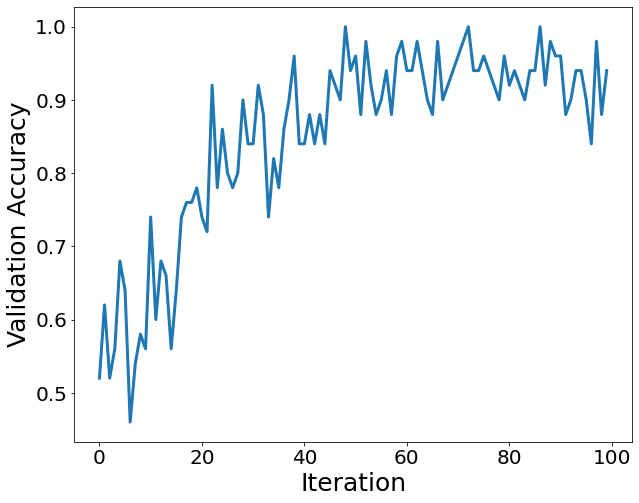

In [33]:
plt.figure(figsize=(10,8))
plt.plot(val_acc,linewidth=3)
plt.xlabel('Iteration',fontsize=25);
plt.ylabel('Validation Accuracy',fontsize=25);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);


## Run Inference on IonQ Backend

In [34]:
import cirq_ionq as ionq

service = ionq.Service(api_key="mEJjblVBIHYnuX7mwWTyHS9JOR6BnXGb")

In [35]:
np_tot = 30;
symbols = sympy.symbols('qconv0:30')
sym_dict = {};
for i in range(len(symbols)):
    sym_dict[symbols[i]] = 0.0;

In [57]:
qpu = False;
img_num = 4;

initial_point = param_values_k[99]

job_id = [];

for i in range(np_tot):
    sym_dict[symbols[i]] = initial_point[i][0] 

circ1 = cirq.Circuit()
circ1 += convert_to_product_circuit(X_test_pc[img_num])
circ1 += model_circuit
circ1 += cirq.measure(state_bits[0],key='x')

circuit =cirq.resolve_parameters(circ1,sym_dict)

if(qpu ==False):
    job = service.create_job(circuit=cirq.resolve_parameters(circ1,sym_dict_plus), repetitions=num_shots, target='simulator')
elif(qpu==True):
    job = service.create_job(circuit=cirq.resolve_parameters(circ1,sym_dict_plus), repetitions=num_shots, target='qpu')

job_id.append(job.job_id())



In [58]:
results = (service.get_job(job_id[0])).results()

if(qpu==False):
    output = ( results.probabilities(key='x')[0] - results.probabilities(key='x')[1]  )    

elif(qpu==True):
    output = ( results.counts(key='x')[0] - results.counts(key='x')[1] )/num_shots 

if(output>0):
    pred = 3;
else:
    pred = 6;
    
print("Image Prediction is : ", pred)
    

Image Prediction is :  3


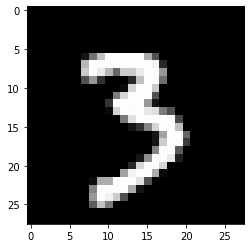

In [59]:
plt.imshow(X_test[img_num],cmap='gray')


## Rerun the training using the IonQ Cloud Backend

In [ ]:
import time 

##The spsa hyperparameters
a=0.05; b=0.05; s=.602; t=.101 ; 
gamma=0.0; max_it=200;
num_shots = 1000;
qpu = False;



num_its=10;  #The number of iterations
NUM_EXAMPLES=5;

kstart=0;
freq = 5;
hinge=True

if(kstart==0):
    loss_value_k = []
    acc_value_k = [];
    param_values_k = [];
    acc_value_0 = []
    loss_value_0=[];
    loss_value = [];
    acc_value = [];
    loss_value1 = [];
    acc_value1 = [];


start = time.time()

for x in range(1):

    print(x);
    l_avg_old = 0
    a_avg_old = 0;

    if(kstart==0):
        initial_point = (0.0*np.random.rand(np_tot,1)*2.0*np.pi).astype('f')
        param_values_k.append(initial_point)

    else:
        initial_point = param_values_k[kstart];
        
    v_old = np.random.rand(np_tot,1)*0.0;    
    
    l_avg = 0;
    a_avg = 0;
    t_avg=0;
    
    
    for k in range(kstart,num_its):
    
        t0 = time.time()
        
        #Adjust the number of samples per iteration to increase at higher iterations
        if(k<=20):
            NUM_EXAMPLES=50;
        if(k>20 and k<70):
            NUM_EXAMPLES=100;
        elif(k>70 and k<100):
            NUM_EXAMPLES=100;
        elif(k>100):
            NUM_EXAMPLES=100;  
            
            
            

        #Get a new mini-batch of images to evaluate the function on
        indices = tf.range(start=0, limit=tf.shape(X_train_pc)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        shuffled_y = tf.gather(y_train_hinge, shuffled_indices)
    
      

        #the SPSA loop
        lr_k =  a/(k+1.0+max_it*.01)**s;
        perturb_k = b / (k+1.0)**t;
        delta_k = 2.0*(2.0*np.random.rand(np_tot,1)-1.0).astype('f')
       
    
        jobid_plus = [];
        jobid_minus = [];

        sym_dict_plus = {}
        sym_dict_minus = {}
        
        #Set the parameters for the two circuits
        for i in range(np_tot):
            sym_dict_plus[symbols[i]] = initial_point[i][0] + perturb_k*delta_k[i][0]
            sym_dict_minus[symbols[i]] = initial_point[i][0] - perturb_k*delta_k[i][0]


        
        #Submit the jobs
        for i in range(NUM_EXAMPLES):
            
            
            circ1 = cirq.Circuit()
            circ1 += convert_to_product_circuit(X_train_pc[shuffled_indices[i]])
            circ1 += model_circuit
            circ1 += cirq.measure(state_bits[0],key='x')
            

            job_plus = service.create_job(circuit=cirq.resolve_parameters(circ1,sym_dict_plus), repetitions=num_shots, target='simulator')
            job_minus = service.create_job(circuit=cirq.resolve_parameters(circ1,sym_dict_minus), repetitions=num_shots, target='simulator')
            
                    
            jobid_plus.append( job_plus.job_id() ) 
            jobid_minus.append( job_minus.job_id() ) 
                
    
        output_plus = [];
        output_minus = [];


        l_plus = 0.0;
        l_minus=0.0;
        
        for i in range(NUM_EXAMPLES):
            
            results_plus = (service.get_job(jobid_plus[i])).results()
            if(qpu==True):
                out_plus = ( results_plus.counts(key='x')[0] - results_plus.counts(key='x')[1] )/num_shots 
            elif(qpu==False):
                out_plus = ( results_plus.probabilities(key='x')[0] - results_plus.probabilities(key='x')[1]  )
                    

            results_minus = (service.get_job(jobid_minus[i])).results()
            if(qpu==True):
                out_minus = ( results_minus.counts(key='x')[0] - results_minus.counts(key='x')[1] )/num_shots  
            elif(qpu==False):
                out_minus = ( results_minus.probabilities(key='x')[0] - results_minus.probabilities(key='x')[1]  )
                    

                    
            output_plus.append( out_plus )
            output_minus.append( out_minus )
                      
            l_plus += mse(output_plus[i:i+1],shuffled_y[i:i+1])
            l_minus += mse(output_minus[i:i+1],shuffled_y[i:i+1])               

                
                
        l_plus = l_plus/NUM_EXAMPLES
        l_minus = l_minus/NUM_EXAMPLES

        a_plus = hinge_accuracy(output_plus,shuffled_y[:NUM_EXAMPLES])
        a_minus = hinge_accuracy(output_minus,shuffled_y[:NUM_EXAMPLES])
    
        
        #Determine the new update parameters
        g_k = ( l_plus - l_minus ) / (2.0*perturb_k);
    
        v_new = gamma*v_old + lr_k*g_k*delta_k
        v_old = v_new;
    
        new_point = (initial_point - v_new.numpy() ).astype('f');
    
        initial_point = new_point;
        
        param_values_k.append(initial_point)

        l_avg += ((l_plus+l_minus)/2.0).numpy();
        a_avg += ((a_plus+a_minus)/2.0).numpy();

        t1 = time.time();
        t_avg += (t1-t0);
       


        print(k, l_plus.numpy(), l_minus.numpy(), a_plus.numpy(), a_minus.numpy())

        loss_value_0.append( ((l_plus+l_minus)/2.0).numpy() )
        acc_value_0.append( ((a_plus+a_minus)/2.0).numpy() )


        if(k%freq==0):   
            if(k==0):
                l_avg = round(l_avg,5)
                a_avg = round(a_avg,5)
            else:
                l_avg = round(l_avg/freq,5)
                a_avg = round(a_avg/freq,5)
            loss_value.append(l_avg)
            acc_value.append(a_avg)
            
            print("avg: ", k, l_avg, a_avg, '\t\t', round(lr_k,5), round(perturb_k,5), round(g_k.numpy(),5), t_avg)
            
            l_avg_old = l_avg;
            a_avg_old= a_avg;
            l_avg = 0;
            a_avg=0;
            t_avg = 0
            

    loss_value_k.append(loss_value)
    acc_value_k.append(acc_value)
    
end=time.time()
